# GCHP Basic Data Visualization

This notebook is meant for quick plotting of GCHP output. Functionality includes regridding between any cubed sphere and lat-lon resolutions, and plotting either or both on the same figure. 

## Overview of this Notebook

* Import dependencies
* Define functions: utility, regridding, and plotting
* Define data source
* Explore GCHP data using xarray and numpy
* Create regridding weights
* Plot data
* Save GCHP plots to a pdf

## Import dependencies

In [1]:
import os
import numpy as np
import xarray as xr
import cubedsphere as cs
import xesmf as xe
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from cartopy import crs
from cartopy.mpl.geoaxes import GeoAxes

%matplotlib inline
import warnings; warnings.filterwarnings("ignore")

# Also define colormap. Colormap file source: https://bitbucket.org/gcst/gcpy
rgb_WhGrYlRd = np.genfromtxt('/n/home08/elundgren/GC/python/WhGrYlRd.txt',delimiter=' ')
WhGrYlRd = ListedColormap(rgb_WhGrYlRd/255.0)

## Define utility functions

In [2]:
def get_gchp_filepath(datadir, collection, day, time):
    filepath = os.path.join(datadir, 'GCHP.{}.{}_{}z.nc4'.format(collection,day,time))
    if os.path.isfile(filepath):
        print('GCHP path exists: {}'.format(filepath))
    else:
        print('ERROR! GCHP path does not exist: {}'.format(filepath))
    return filepath

In [3]:
def get_varnames(dgchp):
    varsAll = [k for k in dgchp.data_vars.keys()]
    vars2D = [v for v in varsAll if dgchp[v].ndim == 3]
    vars3D = [v for v in varsAll if dgchp[v].ndim == 4]
    print('{} variables ({} are 2-dim and {} are 3-dim)'.format(len(varsAll), len(vars2D), len(vars3D)))
    return [varsAll, vars2D, vars3D]

## Define functions for regridding

These functions utilize the xESMF package and the cubedsphere package developed by Jaiwei Zhuang, a graduate student at Harvard University. More specifically I use the cubedsphere package CSGrid class and the xESMF package Regridder class. The latter serves as a wrapper for the ESMF/ESMPy packages. These tools enable simple conservative regridding between lat/lon and cubed sphere horizontal grids as specifically defined by the NASA Global Modeling and Assimilation Office (GMAO). See http://xesmf.readthedocs.io/en/latest/ and https://github.com/JiaweiZhuang/cubedsphere for more information. 

### Function to make lat/lon half-polar grid (native horizontal grid used in GEOS-Chem Classic)

In [4]:
def make_grid_LL(llres):
    [dlat,dlon] = list(map(float, llres.split('x')))
    lon_b = np.linspace(-180 - dlon/2, 180 - dlon/2, int(360/dlon) + 1, endpoint=True)
    lat_b = np.linspace(-90 - dlat/2, 90 + dlat/2, int(180/dlat) + 2, endpoint=True).clip(-90,90)
    lat = (lat_b[1:] + lat_b[:-1]) / 2
    lon = (lon_b[1:] + lon_b[:-1]) / 2
    llgrid = {'lat': lat, 
              'lon': lon, 
              'lat_b': lat_b, 
              'lon_b': lon_b}
    return llgrid

### Function to make GMAO cubed sphere grid (native horizontal grid used in GCHP)

In [5]:
def make_grid_CS(csres):
    csgrid = cs.csgrid_GMAO(csres)
    csgrid_list = [None]*6
    for i in range(6):
        csgrid_list[i] = {'lat': csgrid['lat'][i], 
                          'lon': csgrid['lon'][i],
                          'lat_b': csgrid['lat_b'][i], 
                          'lon_b': csgrid['lon_b'][i]}
    return [csgrid, csgrid_list]

### Function to create a regridder object for regridding cubed sphere to lat-lon

In [6]:
def make_regridder_C2L( csres_in, llres_out, weightsdir='.', reuse_weights=False,  ):
    csgrid, csgrid_list = make_grid_CS(csres_in)
    llgrid = make_grid_LL(llres_out)
    regridder_list = []
    for i in range(6):
        weightsfile = os.path.join(weightsdir, 'conservative_c{}_{}_{}.nc'.format(str(csres_in), llres_out, str(i)))
        regridder = xe.Regridder(csgrid_list[i], llgrid, method='conservative', filename=weightsfile, reuse_weights=reuse_weights)
        regridder_list.append(regridder)
    return regridder_list

### Function to create a regridder object for regridding between different resolution between lat-lon grids

This is not used for plotting GCHP but is included for general reference.

In [7]:
def make_regridder_L2L( llres_in, llres_out, weightsdir='.', reuse_weights=False ):
    llgrid_in = make_grid_LL(llres_in)
    llgrid_out = make_grid_LL(llres_out)
    weightsfile = os.path.join(weightsdir,'conservative_{}_{}.nc'.format(llres_in, llres_out))
    regridder = xe.Regridder(llgrid_in, llgrid_out, method='conservative', filename=weightsfile, reuse_weights=reuse_weights)
    return regridder

## Define function to make plots for single vertical level global map

Note: This function can regrid GCHP on-the-fly using the pre-generated weights. There are many other optional functionalities enable via optional arguments.

In [8]:
def plot_level_map(dgchp, varlist=None, weightsdir='.', ilev=0, itime=0, 
                   llres='1x1.25', savepdf=False, pdfname='gchp_map.pdf', 
                   full_ratio_range=False, grid='cs'):
    
    # If no varlist is passed, plot all (surface only for 3D)
    if varlist == None:
        varlist = [k for k in dgchp.data_vars.keys()]
        print('Plotting all variables in collection')
    n_var = len(varlist)
    
    # Get cubed sphere grid
    csres = dgchp['lon'].size
    [csgrid, csgrid_list] = make_grid_CS(csres)
    
    # If regridding, get cubed sphere regridder and lat-lon information
    if grid != 'cs_only':
        cs_regridder_list = make_regridder_C2L(csres, llres, weightsdir=weightsdir, 
                                               reuse_weights=True)
        llgrid = make_grid_LL(llres)
        [minlon, maxlon] = [min(llgrid['lon_b']), max(llgrid['lon_b'])]
        [minlat, maxlat] = [min(llgrid['lat_b']), max(llgrid['lat_b'])]

    # Create pdf (if saving)
    if savepdf:
        print('\nCreating {}'.format(pdfname))
        pdf = PdfPages(pdfname)

    # Loop over variables
    for ivar in range(n_var):
        if savepdf: print('{} '.format(ivar), end='')
        varname = varlist[ivar]
            
        # if normalizing by area, adjust units to be per m2, and adjust title string
        units = dgchp[varname].units
                    
        # Slice the data and reshape it
        varndim = dgchp[varname].ndim
        if varndim == 4: 
            ds2 = dgchp[varname].isel(time=itime,lev=ilev)
        elif varndim == 3: 
            ds2 = dgchp[varname].isel(time=itime)
        csdata = ds2.data.reshape(6,csres,csres)
        
        # If regridding, regrid the slices
        if grid != 'cs':
            gchp_ll = np.zeros([llgrid['lat'].size, llgrid['lon'].size])
            for i in range(6):
                regridder = cs_regridder_list[i]
                gchp_ll += regridder(csdata[i])
        
        # Plot both cs and lat-lon (default)
        if grid == 'csll':
            # Get min and max for colorbar limits
            vmin = np.min([csdata.min(), gchp_ll.min()])
            vmax = np.max([csdata.max(), gchp_ll.max()])
            
            # Create 2x1 figure
            figs, ((ax0), (ax1)) = plt.subplots(2, 1, figsize=[10,14], subplot_kw={'projection': crs.PlateCarree()})
            
            # Give the figure a title
            offset = 0.96
            fontsize=24
            if varndim == 4:
                if ilev == 0: levstr = 'Surface'
                elif ilev == 22: levstr = '500 hPa'
                else: levstr = 'Level ' +  str(ilev-1)
                figs.suptitle('{}, {}'.format(varname,levstr), fontsize=fontsize, y=offset)
            elif varndim == 3: 
                figs.suptitle('{}'.format(varname), fontsize=fontsize, y=offset)
            else:
                print('varndim is 2 for {}! Must be 3 or 4.'.format(varname))
            
            # Subplot (0,0): GCHP raw
            ax0.coastlines()       
            masked_csdata = np.ma.masked_where(np.abs(csgrid['lon'] - 180) < 2, csdata) # based on cubedsphere plotCS_quick_raw
            for i in range(6):
                plot0 = ax0.pcolormesh(csgrid['lon_b'][i,:,:], csgrid['lat_b'][i,:,:], masked_csdata[i,:,:], 
                                       cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
            ax0.set_title('GCHP Raw\nC{}'.format(str(csres)))
            cb = plt.colorbar(plot0, ax=ax0, orientation='horizontal', pad=0.10)
            if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
                cb.locator = ticker.MaxNLocator(nbins=4)
                cb.update_ticks()
            cb.set_label(units)            
        
            # Subplot (0,1): GCHP regridded
            ax1.coastlines()
            plot1 = ax1.imshow(gchp_ll, extent=(minlon, maxlon, minlat, maxlat), 
                               cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
            ax1.set_title('GCHP Regridded\n{}'.format(llres))
            cb = plt.colorbar(plot1, ax=ax1, orientation='horizontal', pad=0.10)
            if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
                cb.locator = ticker.MaxNLocator(nbins=4)
                cb.update_ticks()
            cb.set_label(units)
            
        elif grid == 'cs':
            vmin = csdata.min()
            vmax = csdata.max()
            
            # Create single figure
            figs, ((ax0)) = plt.subplots(1, 1, figsize=[12,8], 
                                         subplot_kw={'projection': crs.PlateCarree()})
            
            # Give the figure a title
            offset = 0.96
            fontsize=24
            if varndim == 4:
                if ilev == 0: levstr = 'Surface'
                elif ilev == 22: levstr = '500 hPa'
                else: levstr = 'Level ' +  str(ilev-1)
                figs.suptitle('{}, {}'.format(varname,levstr), fontsize=fontsize, y=offset)
            elif varndim == 3: 
                figs.suptitle('{}'.format(varname), fontsize=fontsize, y=offset)
            else:
                print('varndim is 2 for {}! Must be 3 or 4.'.format(varname))
            
            # Same as subplot (0,0): GCHP raw
            ax0.coastlines()       
            masked_csdata = np.ma.masked_where(np.abs(csgrid['lon'] - 180) < 2, csdata) # based on cubedsphere plotCS_quick_raw
            for i in range(6):
                plot0 = ax0.pcolormesh(csgrid['lon_b'][i,:,:], csgrid['lat_b'][i,:,:], masked_csdata[i,:,:], 
                                       cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
            ax0.set_title('GCHP Raw\nC{}'.format(str(csres)))
            cb = plt.colorbar(plot0, ax=ax0, orientation='horizontal', pad=0.10)
            if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
                cb.locator = ticker.MaxNLocator(nbins=4)
                cb.update_ticks()
            cb.set_label(units)  
            
        elif grid == 'll':
            vmin = gchp_ll.min()
            vmax = gchp_ll.max()
            
            # Create single figure
            figs, ((ax1)) = plt.subplots(1, 1, figsize=[12,9], subplot_kw={'projection': crs.PlateCarree()})
            
            # Give the figure a title
            offset = 0.96
            fontsize=24
            if varndim == 4:
                if ilev == 0: levstr = 'Surface'
                elif ilev == 22: levstr = '500 hPa'
                else: levstr = 'Level ' +  str(ilev-1)
                figs.suptitle('{}, {}'.format(varname,levstr), fontsize=fontsize, y=offset)
            elif varndim == 3: 
                figs.suptitle('{}'.format(varname), fontsize=fontsize, y=offset)
            else:
                print('varndim is 2 for {}! Must be 3 or 4.'.format(varname))
            
            # Same as subplot (0,1): GCHP regridded
            ax1.coastlines()
            plot1 = ax1.imshow(gchp_ll, extent=(minlon, maxlon, minlat, maxlat), 
                               cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
            ax1.set_title('GCHP Regridded\n{}'.format(llres))
            cb = plt.colorbar(plot1, ax=ax1, orientation='horizontal', pad=0.10)
            if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
                cb.locator = ticker.MaxNLocator(nbins=4)
                cb.update_ticks()
            cb.set_label(units)

        else:
            print('Undefined plots argument passed. Use cs, ll or csll for both')
        
        if savepdf:    
            pdf.savefig(figs)
            plt.close(figs)
            
    if savepdf: pdf.close()

## Define function to make plots for zonal mean

Note: Zonal mean is defined as the mean value across a constant latitudinal band. Calculating zonal mean from cubed sphere is not straight-forward. Regridding to lat/lon prior to calculating and plotting is done here instead.

In [9]:
def plot_zonal_mean(dgchp, varlist=None, weightsdir='.', itime=0, llres='1x1.25', savepdf=False, 
                    pdfname='gchp_zonal_mean.pdf', full_ratio_range=False):

    # If no varlist is passed, plot all 3D variables in the dataset
    if varlist == None:
        varlist = [k for k in dgchp.data_vars.keys() if dgchp[k].ndim == 4]
        print('Plotting all 3D variables in collection')
    n_var = len(varlist)
    
    # Get cubed sphere grid and regridder
    csres = dgchp['lon'].size
    [csgrid, csgrid_list] = make_grid_CS(csres)
    cs_regridder_list = make_regridder_C2L(csres, llres, weightsdir=weightsdir, reuse_weights=True)
    
    # Get lat-lon grid
    llgrid = make_grid_LL(llres)
    
    # Universal plot setup
    xtick_positions = np.arange(-90,91,30)
    xticklabels = ['{}$\degree$'.format(x) for x in xtick_positions]
    ytick_positions = np.arange(0,61,20)
    yticklabels = [str(y) for y in ytick_positions]
    
    # Create pdf (if saving)
    if savepdf:
        print('\nCreating {}'.format(pdfname))
        pdf = PdfPages(pdfname)

    # Loop over variables
    for ivar in range(n_var):
        if savepdf: print('{} '.format(ivar), end='')
        varname = varlist[ivar]
        
        # Basic info
        varndim = dgchp[varname].ndim
        units = dgchp[varname].units
        nlev = 72
        extent=(-90,90,0,nlev)
        
        # Slice the data
        ds2 = dgchp[varname].isel(time=itime)
            
        # Regrid the slices
        csdata = ds2.data.reshape(nlev,6,csres,csres).swapaxes(0,1)
        gchp_ll = np.zeros([nlev, llgrid['lat'].size, llgrid['lon'].size])
        for i in range(6):
            regridder = cs_regridder_list[i]
            gchp_ll += regridder(csdata[i])
        
        # Calculate zonal mean of the regridded data
        gchp_zm = gchp_ll.mean(axis=1)
            
        # Get min and max for colorbar limits
        [vmin, vmax] = [gchp_zm.min(), gchp_zm.max()]
        
        # Create 1x1 figure (leave as subplots for easy addition of more plots in figure)
        figs, ((ax0)) = plt.subplots(1, 1, figsize=[10,11], subplot_kw={'projection': crs.PlateCarree()})
        # Give the page a title
        offset = 0.96
        fontsize=25
        figs.suptitle('{}, Zonal Mean'.format(varname), fontsize=fontsize, y=offset)

        # GCHP regridded
        plot0 = ax0.imshow(gchp_zm, cmap=WhGrYlRd, extent=extent, vmin=vmin, vmax=vmax)
        ax0.set_title('GCHP Regridded\n{}'.format(llres))
        ax0.set_aspect('auto')
        ax0.set_xticks(xtick_positions)
        ax0.set_xticklabels(xticklabels)
        ax0.set_yticks(ytick_positions)
        ax0.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot0, ax=ax0, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
            
        if savepdf:    
            pdf.savefig(figs)
            plt.close(figs)
            
    if savepdf: pdf.close()

## Define data source

In [10]:
datadir = '/n/home08/elundgren/GC/testruns/12.0.1/gfortran/gchp_standard/OutputDir'

### Print data files

In [11]:
GCHP_files = [k for k in os.listdir(datadir) if '.nc4' in k]
for k in GCHP_files:
    print(k)

GCHP.SpeciesConc_inst.20160704_0000z.nc4
GCHP.StateMet_inst.20160702_0000z.nc4
GCHP.SpeciesConc_inst.20160705_0000z.nc4
GCHP.StateMet_avg.20160701_1200z.nc4
GCHP.SpeciesConc_inst.20160706_0000z.nc4
GCHP.SpeciesConc_inst.20160707_0000z.nc4
GCHP.StateMet_inst.20160708_0000z.nc4
GCHP.StateMet_avg.20160706_1200z.nc4
GCHP.SpeciesConc_avg.20160707_1200z.nc4
GCHP.StateMet_inst.20160706_0000z.nc4
GCHP.StateMet_inst.20160703_0000z.nc4
GCHP.StateMet_avg.20160707_1200z.nc4
GCHP.StateMet_avg.20160703_1200z.nc4
GCHP.SpeciesConc_avg.20160701_1200z.nc4
GCHP.SpeciesConc_avg.20160705_1200z.nc4
GCHP.StateMet_inst.20160707_0000z.nc4
GCHP.SpeciesConc_avg.20160706_1200z.nc4
GCHP.StateMet_avg.20160702_1200z.nc4
GCHP.SpeciesConc_avg.20160704_1200z.nc4
GCHP.StateMet_inst.20160704_0000z.nc4
GCHP.SpeciesConc_inst.20160708_0000z.nc4
GCHP.StateMet_inst.20160705_0000z.nc4
GCHP.StateMet_avg.20160705_1200z.nc4
GCHP.SpeciesConc_inst.20160703_0000z.nc4
GCHP.SpeciesConc_avg.20160702_1200z.nc4
GCHP.SpeciesConc_avg.20160

## Explore one file

In [12]:
fcollection = 'SpeciesConc_avg'
fday = '20160704'
ftime='1200'     
fgchp = get_gchp_filepath(datadir, fcollection, fday, ftime)

GCHP path exists: /n/home08/elundgren/GC/testruns/12.0.1/gfortran/gchp_standard/OutputDir/GCHP.SpeciesConc_avg.20160704_1200z.nc4


In [13]:
ds = xr.open_dataset(fgchp)
ds

<xarray.Dataset>
Dimensions:               (lat: 540, lev: 72, lon: 90, time: 1)
Coordinates:
  * lon                   (lon) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * lat                   (lat) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * lev                   (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * time                  (time) datetime64[ns] 2016-07-04T12:00:00
Data variables:
    SpeciesConc_ACET      (time, lev, lat, lon) float64 2.572e-09 2.928e-09 ...
    SpeciesConc_ACTA      (time, lev, lat, lon) float64 9.744e-12 9.559e-12 ...
    SpeciesConc_AERI      (time, lev, lat, lon) float64 1.478e-13 1.934e-13 ...
    SpeciesConc_ALD2      (time, lev, lat, lon) float64 5.725e-10 6.88e-10 ...
    SpeciesConc_ALK4      (time, lev, lat, lon) float64 7.45e-10 6.457e-10 ...
    SpeciesConc_BCPI      (time, lev, lat, lon) float64 2.395e-10 2.849e-10 ...
    SpeciesConc_BCPO      (time, lev, lat, lon) float64 6.594e-12 9.845e-12 ...
    SpeciesConc_BENZ    

In [14]:
[varsAll, vars2D, vars3D] = get_varnames(ds)
#varsAll

161 variables (0 are 2-dim and 161 are 3-dim)


### Look at one variable more closely

In [15]:
varname='SpeciesConc_O3'
ds_data = ds[varname]
print('Variable array type: {}'.format(type(ds_data)))
print('Variable values array type: {}'.format(type(ds_data.values)))
print('Array shape: {}'.format(ds_data.shape))
print('GCHP mean concentration: {}'.format(ds_data.values.mean()))

Variable array type: <class 'xarray.core.dataarray.DataArray'>
Variable values array type: <class 'numpy.ndarray'>
Array shape: (1, 72, 540, 90)
GCHP mean concentration: 1.819418965614903e-06


## Create regridding weights for data native resolution

The xESMF Regridder object can create weights for regridding from one grid resolution to another, or it can be provided weights that are pre-generated to save time. Generating weights therefore only needs to be done once for each combination of input and output grid type and resolution. This can be done by calling the make_regridder functions and passing reuse_weights=False. Below is an example for creating and saving weights. If you later use functions in this notebook to plot at a different resolutions then new weights will be created on the fly and re-used for subsequent plots. Be sure to pass weightsdir=weightsdir to retrieve or save weights to the same location.

In [16]:
weightsdir = '/n/home08/elundgren/GC/python/regrid_weights'
csres = 24
llres = '4x5'
%timeit regridder_C2L_list = make_regridder_C2L(csres, llres, weightsdir=weightsdir, reuse_weights=False)

2.2 s ± 142 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Plot data

### Plot surface ozone on cubed sphere grid
Tip: Use shift-tab to display arguments

CPU times: user 13.8 s, sys: 44.7 ms, total: 13.9 s
Wall time: 14.6 s


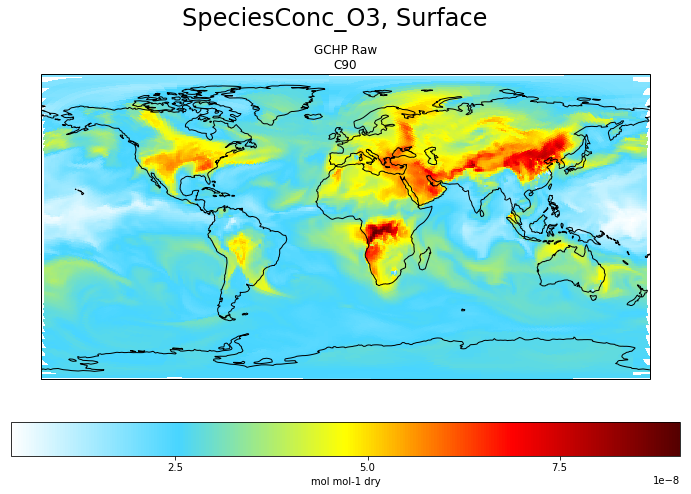

In [17]:
%time plot_level_map(ds, varlist=[varname])

### Plot surface ozone regridded to lat-lon
Note that regridding weights will be computed on the fly since the GCHP data is different than the cs resolution we created regridding weights for in the example.

CPU times: user 13.3 s, sys: 15.5 ms, total: 13.4 s
Wall time: 13.8 s


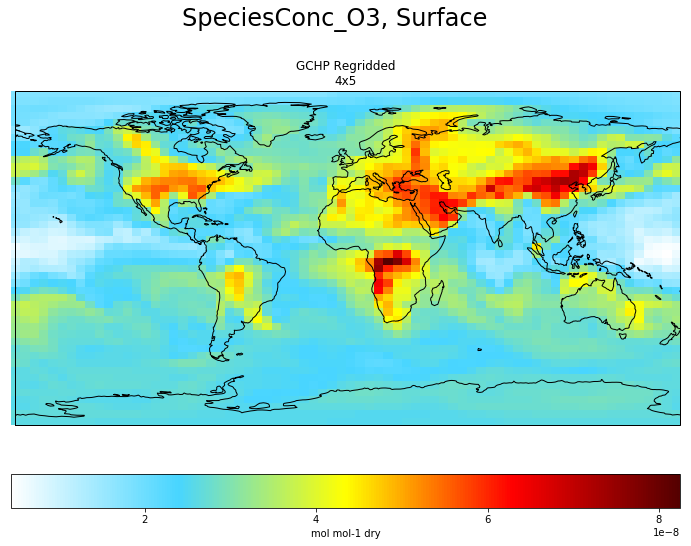

In [18]:
%time plot_level_map(ds, varlist=['SpeciesConc_O3'], weightsdir=weightsdir, grid='ll', llres='4x5')

### Plot L=22 ozone for cubed sphere
Note that the regridding weights created above and are now reused.

CPU times: user 13.8 s, sys: 11.7 ms, total: 13.8 s
Wall time: 14.4 s


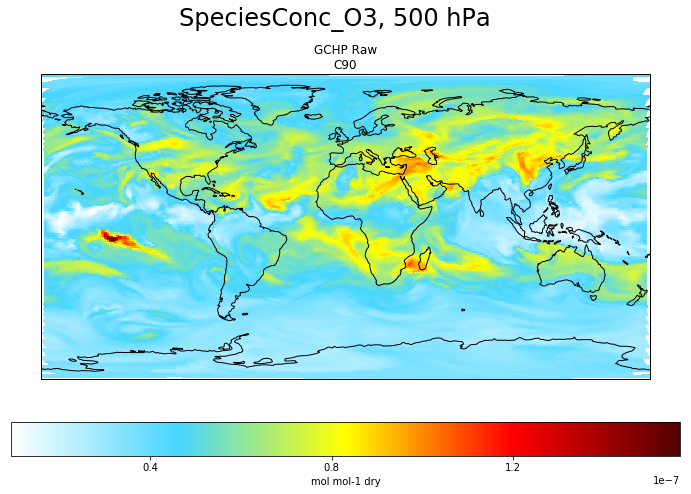

In [19]:
%time plot_level_map(ds, varlist=['SpeciesConc_O3'], ilev=22, weightsdir=weightsdir)

### Plot zonal mean of regridded data using the default lat-lon resolution of 1x1.25

Tip: Use shift-tab over the function to see all possible arguments


CPU times: user 13.6 s, sys: 38.7 ms, total: 13.7 s
Wall time: 14.7 s


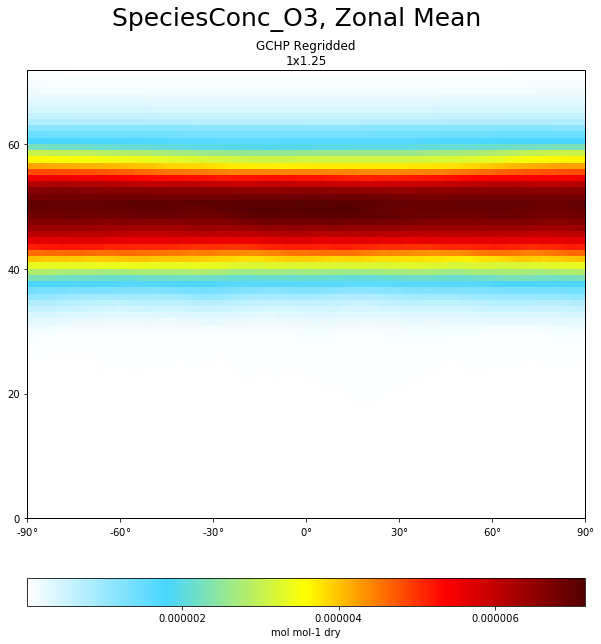

In [20]:
%time plot_zonal_mean(ds, varlist=[varname], weightsdir=weightsdir )

## Save GCHP plots to a pdf for any collection and subset of variables

In [21]:
fcollection = 'SpeciesConc_avg'
fday = '20160701'
ftime = '1200'
fgchp = get_gchp_filepath(datadir, fcollection, fday, ftime)
ds = xr.open_dataset(fgchp)

GCHP path exists: /n/home08/elundgren/GC/testruns/12.0.1/gfortran/gchp_standard/OutputDir/GCHP.SpeciesConc_avg.20160701_1200z.nc4


In [22]:
[varsAll, vars2D, vars3D] = get_varnames(ds)
#vars3D

161 variables (0 are 2-dim and 161 are 3-dim)


In [23]:
varlist=[k for k in vars3D if 'DST' in k]
varlist

['SpeciesConc_DST1',
 'SpeciesConc_DST2',
 'SpeciesConc_DST3',
 'SpeciesConc_DST4']

In [24]:
# Define path for storing plots
plotsdir = '.'

In [25]:
pdfname = os.path.join(plotsdir,'{}_Dust_Surface.pdf'.format(fcollection))
%time plot_level_map(ds, varlist=varlist, ilev=0, weightsdir=weightsdir, savepdf=True, pdfname=pdfname )


Creating ./SpeciesConc_avg_Dust_Surface.pdf
0 1 2 3 CPU times: user 44.4 s, sys: 98.7 ms, total: 44.5 s
Wall time: 44.9 s


In [26]:
ilev=22
pdfname = os.path.join(plotsdir,'{}_Dust_L{}.pdf'.format(fcollection, ilev))
%time plot_level_map(ds, varlist=varlist, ilev=ilev, weightsdir=weightsdir, savepdf=True, pdfname=pdfname )


Creating ./SpeciesConc_avg_Dust_L22.pdf
0 1 2 3 CPU times: user 44.2 s, sys: 51.9 ms, total: 44.2 s
Wall time: 45.5 s


In [27]:
pdfname = os.path.join(plotsdir,'{}_Dust_Zonal_Mean.pdf'.format(fcollection))
%time plot_zonal_mean(ds, varlist=varlist, weightsdir=weightsdir, savepdf=True, pdfname=pdfname )


Creating ./SpeciesConc_avg_Dust_Zonal_Mean.pdf
0 1 2 3 CPU times: user 15 s, sys: 67.9 ms, total: 15.1 s
Wall time: 15.3 s
